## 3-model training with k-fold
## importing libraries

In [1]:
import os

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection
import torch
import torch.nn as nn
import torch.optim as optim
import torchinfo
import torchvision
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torch.utils.data import DataLoader
from torchinfo import summary
from torchvision import datasets, transforms
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR

In [2]:
#configure the device 
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cuda device.


In [3]:
train_dir= os.path.join("../data_p2/data_undersampled2/train")
print (os.listdir(train_dir))

['cassava-healthy', 'cassava-mosaic-disease-cmd', 'cassava-brown-streak-disease-cbsd', 'cassava-green-mottle-cgm', 'cassava-bacterial-blight-cbb']


In [4]:
import sys
sys.path.append("../src")

In [5]:
from utils.ConvertToRGB import ConvertToRGB
from utils.class_counts import class_counts

mean= [0.4326, 0.4952, 0.3120]
std= [0.2179, 0.2214, 0.2091]
transform_norm = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean,std=std)
    ]
)

In [6]:
dataset =datasets.ImageFolder(root=train_dir, transform =transform_norm)
classes = dataset.classes
print (classes)

['cassava-bacterial-blight-cbb', 'cassava-brown-streak-disease-cbsd', 'cassava-green-mottle-cgm', 'cassava-healthy', 'cassava-mosaic-disease-cmd']


## plotting classes counts 

100%|██████████| 7616/7616 [01:54<00:00, 66.44it/s]


<Axes: >

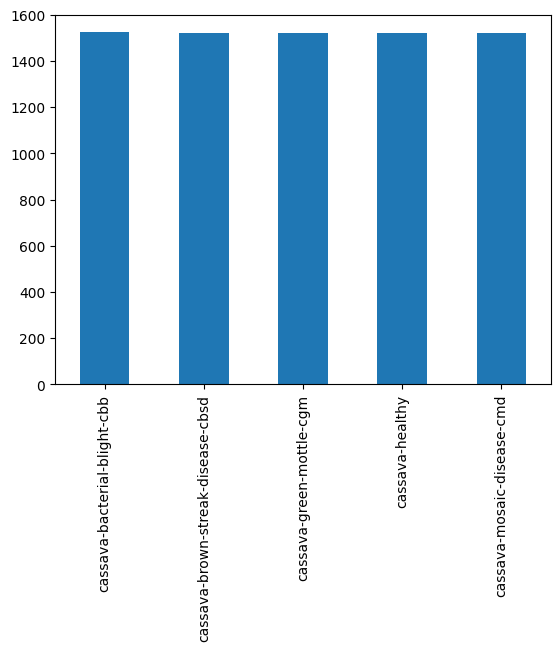

In [7]:
counts = class_counts(dataset)
counts.plot(kind="bar")

In [8]:
### creating a dataloader 
batch_size = 32
dataset_loader = DataLoader(dataset,batch_size= batch_size )

print(f"Batch shape: {next(iter(dataset_loader))[0].shape}")

Batch shape: torch.Size([32, 3, 224, 224])


## Model Selection for transferlearning 

In [9]:
# intialize the model 
model =torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)

#freaze the models weights 

for param in model.parameters():
    param.requires_grad = False

# Unfreeze layer4
for param in model.layer4.parameters():
    param.requires_grad = True
    
print (model)    

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
# get the number of in_features 

in_feat = model.fc.in_features
in_feat

# built the modified last layer 

import torch.nn as nn

modified_last_layer = nn.Sequential(
    nn.Linear(in_features=in_feat, out_features=512),
    nn.BatchNorm1d(512), 
    nn.ReLU(),
    nn.Dropout(p=0.5),

    nn.Linear(in_features=512, out_features=256),
    nn.BatchNorm1d(256), 
    nn.ReLU(),
    nn.Dropout(p=0.5),

    nn.Linear(in_features=256, out_features=64),
    nn.BatchNorm1d(64),  
    nn.ReLU(),
    nn.Dropout(p=0.3),

    nn.Linear(in_features=64, out_features=5)
)


#changing last layer
model.fc=modified_last_layer

print (model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
# define model metrics 

loss_fn =nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=0.0001,
    weight_decay=1e-3
)


#place model on device 

model.to(device)
print (next(model.parameters()).device)



cuda:0


In [12]:
# getting information of model 
height = 224
width = 224
batch_size=32 

summary(model, input_size=(batch_size,3,height, width))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 5]                   --
├─Conv2d: 1-1                            [32, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        (128)
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [32, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          (4,096)
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          (36,864)
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]   

### K-fold Cross-Validation

In [13]:
k = 5

kfold_splitter = sklearn.model_selection.KFold(n_splits=k, shuffle=True, random_state=42)

train_nums, val_nums = next(kfold_splitter.split(range(100)))
fold_fraction = len(val_nums) / (len(train_nums) + len(val_nums))
print(f"One fold is {100*fold_fraction:.2f}%")

One fold is 20.00%


In [14]:
def reset_classifier(model):
    for layer in model.fc:
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()


### intialize schedualer

In [15]:
# Period of learning rate decay
step_size = 5
# Multiplicative factor of learning rate decay
gamma = .5

# Initialize the learning rate scheduler
scheduler = StepLR(
    optimizer,
    step_size=step_size,
    gamma=gamma,
)

print(type(scheduler))

<class 'torch.optim.lr_scheduler.StepLR'>


In [16]:
from training import train ,score
from Callbacks import early_stopping
epochs_to_train = 5
training_records = {}
fold_count = 0

for train_idx, val_idx in kfold_splitter.split(np.arange(len(dataset))):
    fold_count += 1
    print("*****Fold {}*****".format(fold_count))

    # Make train and validation data loaders
    train_dataset = torch.utils.data.Subset(dataset, train_idx)
    val_dataset = torch.utils.data.Subset(dataset, val_idx)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Reset the model
    reset_classifier(model)

    # Train
    train_results = train(
    model,
    optimizer,
    loss_fn,
    train_loader,
    val_loader,
    epochs=epochs_to_train,
    device=device,
    scheduler=scheduler,
    checkpoint_path="../model/saved_model.pth",
    early_stopping=early_stopping,
    )

    (
    learning_rates,
    train_losses,
    valid_losses,
    train_accuracies,
    valid_accuracies,
    epochs,
    ) = train_results

    # Save training results for graphing
    training_records[fold_count] = {
        "train_losses": train_losses,
        "valid_losses": valid_losses,
        "valid_accuracies": valid_accuracies,
        "train_accuracies":train_accuracies,
        "learning_rates":learning_rates
    }

    print("\n\n")

*****Fold 1*****
Model evaluation before start of training...


Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]



Starting epoch 1/5


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 1
Training loss: 1.1638
Training accuracy: 62.2382%
Validation loss: 1.2387
Validation accuracy: 53.0599%
Checkpoint saved with validation loss 1.2387


Starting epoch 2/5


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 2
Training loss: 0.8586
Training accuracy: 76.3089%
Validation loss: 1.0678
Validation accuracy: 61.2630%
Checkpoint saved with validation loss 1.0678


Starting epoch 3/5


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 3
Training loss: 0.5710
Training accuracy: 86.9274%
Validation loss: 0.9739
Validation accuracy: 64.9089%
Checkpoint saved with validation loss 0.9739


Starting epoch 4/5


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 4
Training loss: 0.3476
Training accuracy: 93.4555%
Validation loss: 0.9443
Validation accuracy: 65.1042%
Checkpoint saved with validation loss 0.9443


Starting epoch 5/5


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 5
Training loss: 0.2049
Training accuracy: 97.2840%
Validation loss: 0.9302
Validation accuracy: 66.7969%
Checkpoint saved with validation loss 0.9302



*****Fold 2*****
Model evaluation before start of training...


Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]



Starting epoch 1/5


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 1
Training loss: 0.6103
Training accuracy: 91.6885%
Validation loss: 0.5401
Validation accuracy: 95.5078%
Checkpoint saved with validation loss 0.5401


Starting epoch 2/5


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 2
Training loss: 0.4061
Training accuracy: 95.2880%
Validation loss: 0.3983
Validation accuracy: 95.9635%
Checkpoint saved with validation loss 0.3983


Starting epoch 3/5


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 3
Training loss: 0.2652
Training accuracy: 97.3495%
Validation loss: 0.3036
Validation accuracy: 96.7448%
Checkpoint saved with validation loss 0.3036


Starting epoch 4/5


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 4
Training loss: 0.1841
Training accuracy: 98.2166%
Validation loss: 0.2584
Validation accuracy: 96.0286%
Checkpoint saved with validation loss 0.2584


Starting epoch 5/5


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 5
Training loss: 0.1388
Training accuracy: 98.8384%
Validation loss: 0.2302
Validation accuracy: 96.2891%
Checkpoint saved with validation loss 0.2302



*****Fold 3*****
Model evaluation before start of training...


Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]



Starting epoch 1/5


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 1
Training loss: 0.4500
Training accuracy: 98.3312%
Validation loss: 0.4233
Validation accuracy: 98.5026%
Checkpoint saved with validation loss 0.4233


Starting epoch 2/5


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 2
Training loss: 0.3338
Training accuracy: 98.6420%
Validation loss: 0.3207
Validation accuracy: 98.4375%
Checkpoint saved with validation loss 0.3207


Starting epoch 3/5


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 3
Training loss: 0.2574
Training accuracy: 98.9529%
Validation loss: 0.2586
Validation accuracy: 98.4375%
Checkpoint saved with validation loss 0.2586


Starting epoch 4/5


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 4
Training loss: 0.2171
Training accuracy: 98.9856%
Validation loss: 0.2305
Validation accuracy: 98.5026%
Checkpoint saved with validation loss 0.2305


Starting epoch 5/5


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 5
Training loss: 0.1658
Training accuracy: 99.2310%
Validation loss: 0.1823
Validation accuracy: 98.4375%
Checkpoint saved with validation loss 0.1823



*****Fold 4*****
Model evaluation before start of training...


Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]



Starting epoch 1/5


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 1
Training loss: 0.5371
Training accuracy: 98.9038%
Validation loss: 0.5307
Validation accuracy: 98.5677%
Checkpoint saved with validation loss 0.5307


Starting epoch 2/5


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 2
Training loss: 0.4041
Training accuracy: 99.0510%
Validation loss: 0.4026
Validation accuracy: 98.6328%
Checkpoint saved with validation loss 0.4026


Starting epoch 3/5


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 3
Training loss: 0.3315
Training accuracy: 99.3128%
Validation loss: 0.3351
Validation accuracy: 98.8281%
Checkpoint saved with validation loss 0.3351


Starting epoch 4/5


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 4
Training loss: 0.2947
Training accuracy: 99.2310%
Validation loss: 0.3064
Validation accuracy: 98.6328%
Checkpoint saved with validation loss 0.3064


Starting epoch 5/5


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 5
Training loss: 0.2587
Training accuracy: 99.2474%
Validation loss: 0.2717
Validation accuracy: 98.5677%
Checkpoint saved with validation loss 0.2717



*****Fold 5*****
Model evaluation before start of training...


Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]



Starting epoch 1/5


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 1
Training loss: 0.6764
Training accuracy: 99.1001%
Validation loss: 0.6592
Validation accuracy: 98.8281%
Checkpoint saved with validation loss 0.6592


Starting epoch 2/5


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 2
Training loss: 0.5561
Training accuracy: 99.1329%
Validation loss: 0.5464
Validation accuracy: 98.6328%
Checkpoint saved with validation loss 0.5464


Starting epoch 3/5


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 3
Training loss: 0.4803
Training accuracy: 99.3128%
Validation loss: 0.4793
Validation accuracy: 98.8932%
Checkpoint saved with validation loss 0.4793


Starting epoch 4/5


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 4
Training loss: 0.4357
Training accuracy: 99.1983%
Validation loss: 0.4348
Validation accuracy: 98.6979%
Checkpoint saved with validation loss 0.4348


Starting epoch 5/5


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 5
Training loss: 0.3878
Training accuracy: 99.2965%
Validation loss: 0.3881
Validation accuracy: 98.8281%
Checkpoint saved with validation loss 0.3881





## evaluating the model 
### defining a function for plotting metrics over all folds

In [25]:
def plot_all_folds(data, measurement):
    for fold in data.keys():
        plt.plot(data[fold][measurement], label=f"Fold {fold}, {measurement}")
    plt.xlabel("Epochs")
    plt.legend()

### show losses over epochs 

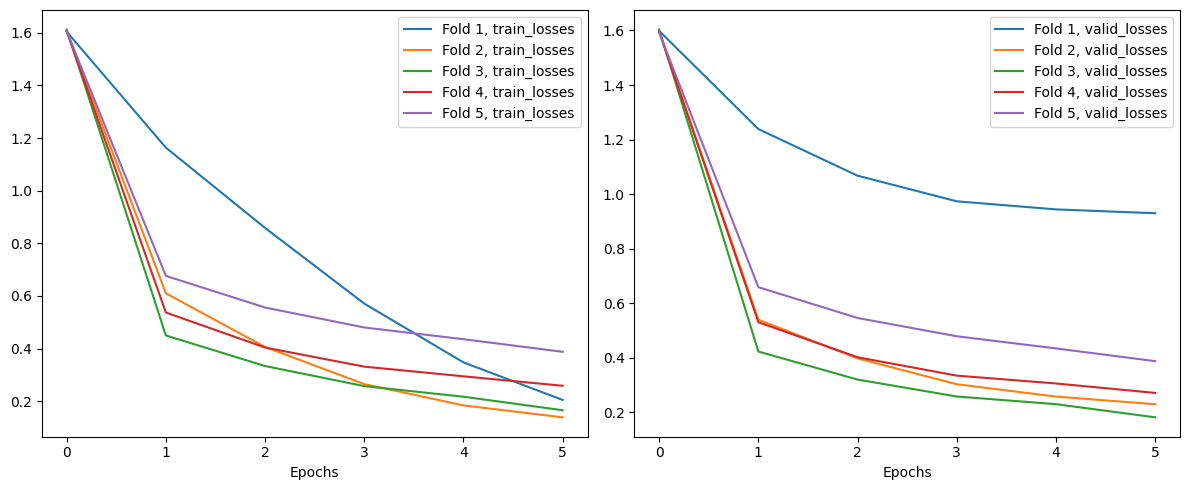

In [26]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plot_all_folds(training_records, "train_losses")

plt.subplot(1,2,2)
plot_all_folds(training_records, "valid_losses")

plt.tight_layout()
plt.show()

### show accuracy over epochs 

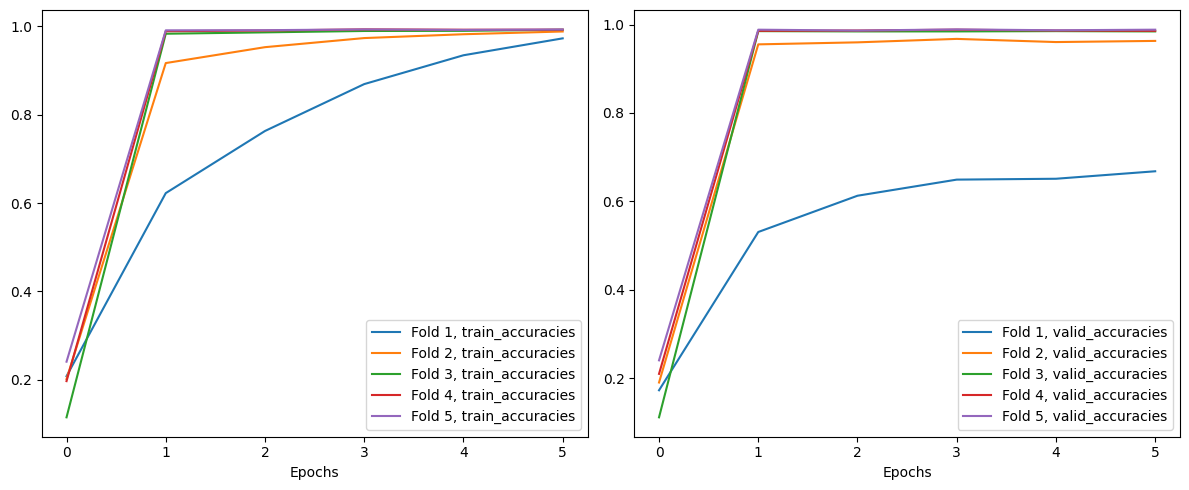

In [29]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plot_all_folds(training_records, "train_accuracies")

plt.subplot(1,2,2)
plot_all_folds(training_records, "valid_accuracies")

plt.tight_layout()
plt.show()

### show LR over epochs 

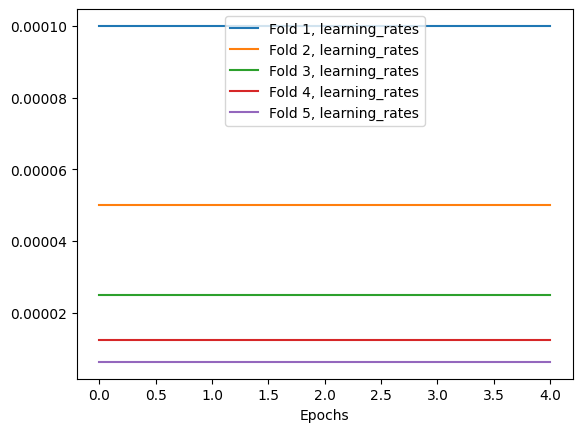

In [30]:
plot_all_folds(training_records, "learning_rates")

### compute the average of the training metrics 

In [31]:
def fold_average(data, measurement):
    return np.mean([data[fold][measurement][-1] for fold in data])


for measurement in training_records[1].keys():
    avg_measure = fold_average(training_records, measurement)
    print(f"Averaged {measurement}: {avg_measure}")

Averaged train_losses: 0.2312171072491898
Averaged valid_losses: 0.400520708586555
Averaged valid_accuracies: 0.9178385416666668
Averaged train_accuracies: 0.9877945026178011
Averaged learning_rates: 3.875000000000001e-05


### evaluate the model on the last validation data at last fold

In [38]:
_, val_idx = list(kfold_splitter.split(np.arange(len(dataset))))[-1]
val_dataset = torch.utils.data.Subset(dataset, val_idx)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
probabilities = predict(model, val_loader, device) 
predictions = torch.argmax(probabilities, dim=1)  


Predicting:   0%|          | 0/48 [00:00<?, ?it/s]

In [39]:
targets = []

for _, labels in tqdm(val_loader):
    targets.extend(labels.tolist())

100%|██████████| 48/48 [00:20<00:00,  2.33it/s]


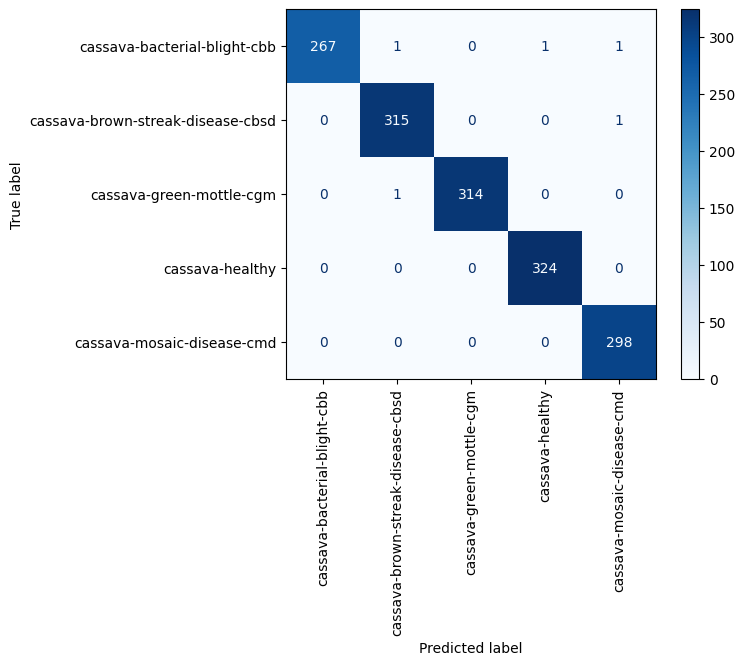

In [41]:
cm = confusion_matrix(targets,predictions.cpu())

disp = ConfusionMatrixDisplay(confusion_matrix=cm , display_labels=classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
plt.show();

## saving the model 

In [42]:
torch.save(model, "../model/kfold_model_full.pth")
